In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snowuwu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:

 # Path to positive reviews
pos_file = r"rt-polarity.pos" 
 # Path to negative reviews
neg_file = r"rt-polarity.neg" 

In [10]:
def load_data(pos_file, neg_file):
    with open(pos_file, "r", encoding="ISO-8859-1") as f:
        positive_data = f.readlines()
    with open(neg_file, "r", encoding="ISO-8859-1") as f:
        negative_data = f.readlines()
    return positive_data, negative_data


positive_data, negative_data = load_data(pos_file, neg_file)

In [11]:
def preprocess_text(text):
    text = text.lower()
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)


positive_data = [preprocess_text(text) for text in positive_data]
negative_data = [preprocess_text(text) for text in negative_data]

In [12]:
def split_data(positive_data, negative_data):
    # Training set (first 4,000 of each class)
    train_pos, train_neg = positive_data[:4000], negative_data[:4000]
    # Validation set (next 500 of each class)
    val_pos, val_neg = positive_data[4000:4500], negative_data[4000:4500]
    # Test set (last 831 of each class)
    test_pos, test_neg = positive_data[4500:], negative_data[4500:]

    return (train_pos, train_neg), (val_pos, val_neg), (test_pos, test_neg)


(train_pos, train_neg), (val_pos, val_neg), (test_pos, test_neg) = split_data(
    positive_data, negative_data
)

In [13]:
def prepare_data(pos, neg):
    texts = pos + neg
    labels = [1] * len(pos) + [0] * len(neg)
    return texts, np.array(labels)


train_texts, train_labels = prepare_data(train_pos, train_neg)
val_texts, val_labels = prepare_data(val_pos, val_neg)
test_texts, test_labels = prepare_data(test_pos, test_neg)

In [14]:
max_vocab_size = 10000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(train_texts)


def tokenize_pad(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_sequence_length)


train_sequences = tokenize_pad(train_texts)
val_sequences = tokenize_pad(val_texts)
test_sequences = tokenize_pad(test_texts)

In [15]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(max_vocab_size, 128),  
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)


model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
history = model.fit(
    train_sequences,
    train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=5,
    batch_size=64,
)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5693 - loss: 0.6754 - val_accuracy: 0.7060 - val_loss: 0.5686
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8334 - loss: 0.3929 - val_accuracy: 0.7620 - val_loss: 0.5122
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9304 - loss: 0.1938 - val_accuracy: 0.7510 - val_loss: 0.5904
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9647 - loss: 0.1081 - val_accuracy: 0.7510 - val_loss: 0.7473
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9818 - loss: 0.0585 - val_accuracy: 0.7510 - val_loss: 0.9144


In [17]:
test_predictions = (model.predict(test_sequences) > 0.5).astype("int32")


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [18]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Report
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")

# Detailed classification report
print(
    classification_report(
        test_labels, test_predictions, target_names=["Negative", "Positive"]
    )
)

Confusion Matrix:
[[642 189]
 [242 589]]
Precision: 0.7571, Recall: 0.7088, F1-Score: 0.7321
              precision    recall  f1-score   support

    Negative       0.73      0.77      0.75       831
    Positive       0.76      0.71      0.73       831

    accuracy                           0.74      1662
   macro avg       0.74      0.74      0.74      1662
weighted avg       0.74      0.74      0.74      1662



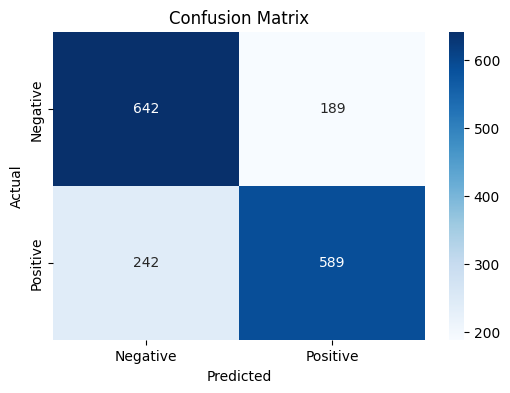

Confusion Matrix:
[[642 189]
 [242 589]]
True Positives (TP): 589, True Negatives (TN): 642
False Positives (FP): 189, False Negatives (FN): 242


In [19]:


# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, labels=["Negative", "Positive"])

# Print evaluation metrics
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"True Positives (TP): {tp}, True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}, False Negatives (FN): {fn}")





Precision: 0.7571
Recall: 0.7088
F1-Score: 0.7321


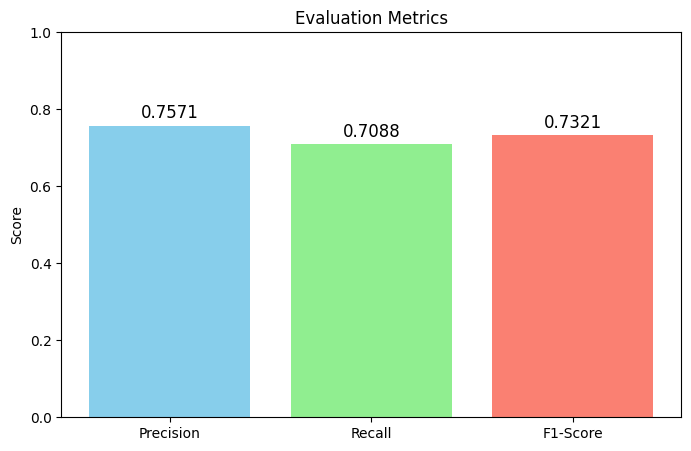

In [20]:
# Plot Precision, Recall, F1-Score
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
metrics = ['Precision', 'Recall', 'F1-Score']
scores = [precision, recall, f1_score]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center', fontsize=12)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.show()